In [4]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as mp
import seaborn as sb

from pathlib import Path
from IPython.display import display
from prophet import Prophet
from scipy.stats import f_oneway

db = sqlite3.connect('../data/movies_project.db')

movies_df = pd.read_sql_query("SELECT * FROM movies", db)
starring_df = pd.read_sql_query("SELECT * FROM starring", db)
genres_df = pd.read_sql_query("SELECT * FROM genres", db)
directors_df = pd.read_sql_query("SELECT * FROM directors", db)
platforms_df = pd.read_sql_query("SELECT * FROM platforms", db)

filtered_movies = movies_df.loc[(movies_df['revenue']>0)&(movies_df['budget']>= 900000)]


#### Phase 5 — Runtime & Budget Patterns
Question: *Is there a measurable relationship between film length and production budget?*

To explore this, I first extracted films with valid budgets, revenues, and runtimes:

In [5]:
query = """
SELECT m.title, m.minutes, m.ratings, m.budget
FROM movies m
WHERE m.revenue > 0 AND m.minutes > 0 AND m.budget > 900000 AND ratings > 0
ORDER BY m.minutes DESC, m.budget DESC;
"""

q9 = pd.read_sql_query(query,db)
display(q9)


,title,minutes,ratings,budget
0,The Chosen: Season 4,546,9.2,40000000
1,The Chosen: Last Supper,463,8.5,48000000
2,Who Knows Knows,400,6.0,2300000
3,Carlos,339,7.2,18000000
4,The French Revolution,335,7.6,50000000
...,...,...,...,...
10241,The New Workout Plan,8,8.0,1000000
10242,Pickled Pink,6,6.5,2436635
10243,Pinkfinger,6,6.4,2221487
10244,Buzzin',5,3.0,1747037


Tabular results alone made patterns hard to detect, so I binned runtimes and compared average budgets across segments:

Runtimes were grouped into five segments (<90, 90–120, etc.) to compare average budgets across natural runtime categories.”

/var/folders/rf/nmgw7vy94qd92jnmrkp95k2h0000gn/T/ipykernel_67237/3827973429.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_movies['runtime_bin'] = pd.cut(filtered_movies['minutes'], bins=bins, labels=labels, include_lowest=True)
/var/folders/rf/nmgw7vy94qd92jnmrkp95k2h0000gn/T/ipykernel_67237/3827973429.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  avg_budget = filtered_movies.groupby('runtime_bin')['budget'].mean()


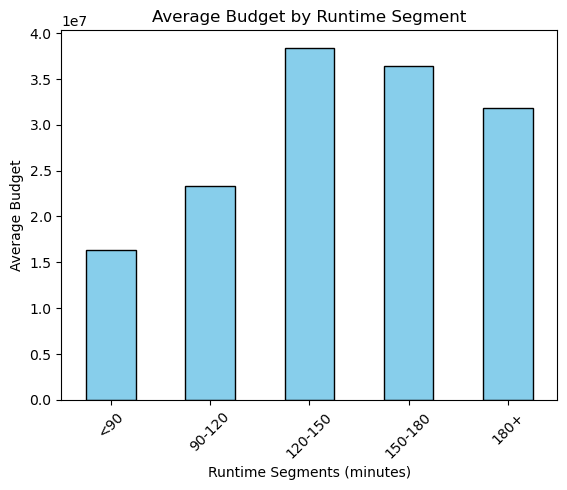

In [6]:
# Define bins
bins = [0, 90, 120, 150, 180, 240]
labels = ['<90', '90-120', '120-150', '150-180', '180+']

filtered_movies['runtime_bin'] = pd.cut(filtered_movies['minutes'], bins=bins, labels=labels, include_lowest=True)

# Compute average budget per runtime segment
avg_budget = filtered_movies.groupby('runtime_bin')['budget'].mean()

# Plot as bar chart
avg_budget.plot(kind='bar', color='skyblue', edgecolor='black')
mp.xlabel('Runtime Segments (minutes)')
mp.ylabel('Average Budget')
mp.title('Average Budget by Runtime Segment')
mp.xticks(rotation=45)
mp.show()


#### Observation:
Film budgets increase sharply for movies over 90 minutes, peaking in the 120–150 minute range where average budgets excels from $2.3M to $3.8M. Beyond this "sweet spot," average budgets decrease, with those for films over 180 minutes falling to approximately $3.3M. 


#### Question: *Which genres are generally longer?*

Average runtime by genre (films ≥ 40 min):

In [7]:
query = """
SELECT g.genre, ROUND(AVG(m.minutes),2) avg_runtime
FROM movies m
JOIN genres g on g.movie_id = m.id
WHERE m.minutes >= 40
GROUP BY g.genre
ORDER BY avg(m.minutes) DESC;
"""

q10 = pd.read_sql_query(query,db)
display(q10)

,genre,avg_runtime
0,Action,103.73
1,History,100.41
2,Romance,99.29
3,War,98.27
4,Music,98.06
5,Drama,97.99
6,Thriller,97.56
7,Crime,95.36
8,Mystery,94.44
9,Adventure,94.04


#### Observation: 
- Action (~ 104 min), History (~ 100 min), and Romance (~99 min) top the list.
- Overall, the global film average is ~92.8 minutes.
- Documentary films trend shorter (~78 min).

In [8]:
filtered_movies[['minutes','budget']].corr(method='spearman')

,minutes,budget
minutes,1.000000,0.168592
budget,0.168592,1.000000


In [9]:
filtered_movies[['minutes','budget']].corr(method='pearson')

,minutes,budget
minutes,1.000000,0.149881
budget,0.149881,1.000000


#### Takeaways

- While somewhat positive, budget vs. runtime is not perfectly linear or consistently strong across all runtime segments, indicating other factors likely influence movie ratings beyond just budget or runtime. 
- Long films can be low-budget (e.g., indie epics), and shorter films can still be expensive (e.g., high-VFX animation).


**Business Insight**

- Higher budgets likely reflect production complexity (effects, sets, star salaries) rather than just runtime.

- Studios don’t spend more because a film is long—they spend more when the film type (e.g., Action/Adventure) demands bigger production, and these films also happen to skew slightly longer.